In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["DDEBACKEND"] = "pytorch"
import torch
from torch import nn, optim
import deepxde as dde
from shapely.geometry import Point
import cartopy.feature as cfeature

import sys
sys.path.append("../")

from src.models import ChlorophyllDeepONet
from src.boundary_conds import get_xt_geom, is_in_ocean
from src.pdes import pde
from src.data_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
zarr_ds = load_and_preprocess_data()
data, time, lat, lon, water_mask = prepare_data_for_pinn(zarr_ds)
chl_data = data["CHL_cmes-level3"]

Starting data load and preprocessing...
Starting data preparation for PINN...


In [3]:
geomtime, coastline = get_xt_geom(lat, lon, time)

# Convert numpy arrays to PyTorch tensors
air_temp = torch.tensor(data["air_temp"], dtype=torch.float32)
sst = torch.tensor(data["sst"], dtype=torch.float32)
curr_dir = torch.tensor(data["curr_dir"], dtype=torch.float32)
ug_curr = torch.tensor(data["ug_curr"], dtype=torch.float32)
u_wind = torch.tensor(data["u_wind"], dtype=torch.float32)
v_wind = torch.tensor(data["v_wind"], dtype=torch.float32)
v_curr = torch.tensor(data["v_curr"], dtype=torch.float32)

In [52]:
def pde(x, y):
    lat, lon, t = x[:, 0:1], x[:, 1:2], x[:, 2:3]
    # U = y[:, 0:1]
    # dU_dt = dde.grad.jacobian(y, x, i=0, j=2)
    d2U_dlat2 = dde.grad.hessian(y, x, component=0, i=0, j=0)
    d2U_dlon2 = dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2U_dt2 = dde.grad.hessian(y, x, component=0, i=2, j=2)
    
    # # Environmental factors
    r_air_temp = y[:, 1:2]
    r_sst = y[:, 2:3]
    r_curr_dir = y[:, 3:4]
    r_ug_curr = y[:, 4:5]
    r_u_wind = y[:, 5:6]
    r_v_wind = y[:, 6:7]
    r_v_curr = y[:, 7:8]
    
    # Define the source term rho
    rho = 0.1 * torch.sin(lat) * torch.cos(lon)+ \
          0.05 * torch.sin(2 * torch.pi * t / 365) + \
         (0.5 * r_air_temp + 
           -1.0 * r_sst + 
           0.05 * r_curr_dir + 
           0.15 * r_ug_curr + 
           0.4 * r_u_wind + 
           -0.2 * r_v_wind + 
           0.3 * r_v_curr)
    
    residual = d2U_dlat2 + d2U_dlon2 + d2U_dt2 - rho
    return residual

def robin_bc_func(x, y, grad_y):
    a = 1.0  # Coefficient for the value term
    b = 1.0  # Coefficient for the gradient term
    g = 0.0  # Source term
    return a * y + b * grad_y - g

In [18]:
class ChlorophyllDeepONet(dde.nn.pytorch.deeponet.DeepONet):
    def __init__(self, layer_sizes_branch, layer_sizes_trunk, activation):
        super().__init__(
            layer_sizes_branch, layer_sizes_trunk, activation, "Glorot normal"
        )

        self.branch_net = dde.nn.pytorch.fnn.FNN(
            layer_sizes_branch, activation, "Glorot normal"
        )
        self.trunk_net = dde.nn.pytorch.fnn.FNN(
            layer_sizes_trunk, activation, "Glorot normal"
        )

    def forward(self, inputs):
        x_func = self.branch_net(inputs)
        x_loc = self.trunk_net(inputs)
        if self._output_transform is not None:
            return self._output_transform(self.merge_branch_trunk(x_func, x_loc, -1))
        return self.merge_branch_trunk(x_func, x_loc, -1)

In [53]:
def boundary_condition(x, on_boundary):
    lat = x[0]
    lon = x[1]
    ocean_boundary = is_in_ocean(lat, lon, coastline)
    return on_boundary and ocean_boundary

bc_robin = dde.icbc.RobinBC(geomtime, lambda X, y: y, boundary_condition)
# bc_robin = dde.icbc.RobinBC(geomtime, boundary_condition)
data_pinn = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_robin],
    num_domain=10000,
    num_boundary=2000,
    num_initial=2000,
)

Compiling model...
'compile' took 0.000202 s

Training model...

Step      Train loss              Test loss               Test metric
0         [nan, 9.05e-01]         [nan, 9.05e-01]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 0.048605 s



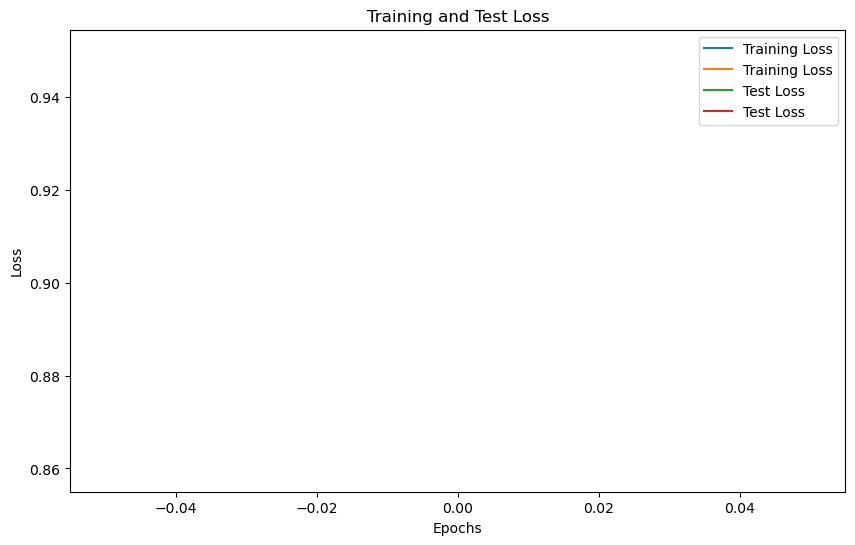

In [54]:
# Neural network model using DeepONet
layer_sizes_branch = [3, 64, 64, 64]
layer_sizes_trunk = [3, 64, 64, 64]
activation = "sigmoid"
net = ChlorophyllDeepONet(layer_sizes_branch, layer_sizes_trunk, activation)

model = dde.Model(data_pinn, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=10000)

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(losshistory.steps, losshistory.loss_train, label="Training Loss")
plt.plot(losshistory.steps, losshistory.loss_test, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.show()

In [28]:
from src.utils import data_to_img

In [36]:
def predict(x):
    with torch.no_grad():
        output = model.predict(x)
    chl_normalized = output[:, 0]
    chl = chl_normalized * data['CHL_cmes-level3_std'] + data['CHL_cmes-level3_mean']
    return chl

In [37]:
# Get boundaries for the mask
lat_min, lat_max = lat.min(), lat.max()
lon_min, lon_max = lon.min(), lon.max()
time_min, time_max = time.min(), time.max()

prediction_time = np.full_like(lat, time_max)
x_pred = np.stack([lat, lon, prediction_time], axis=-1)
chl_pred = predict(x_pred)

chl_pred_grid = np.full(water_mask.shape, np.nan)
chl_pred_grid[water_mask] = chl_pred.flatten()

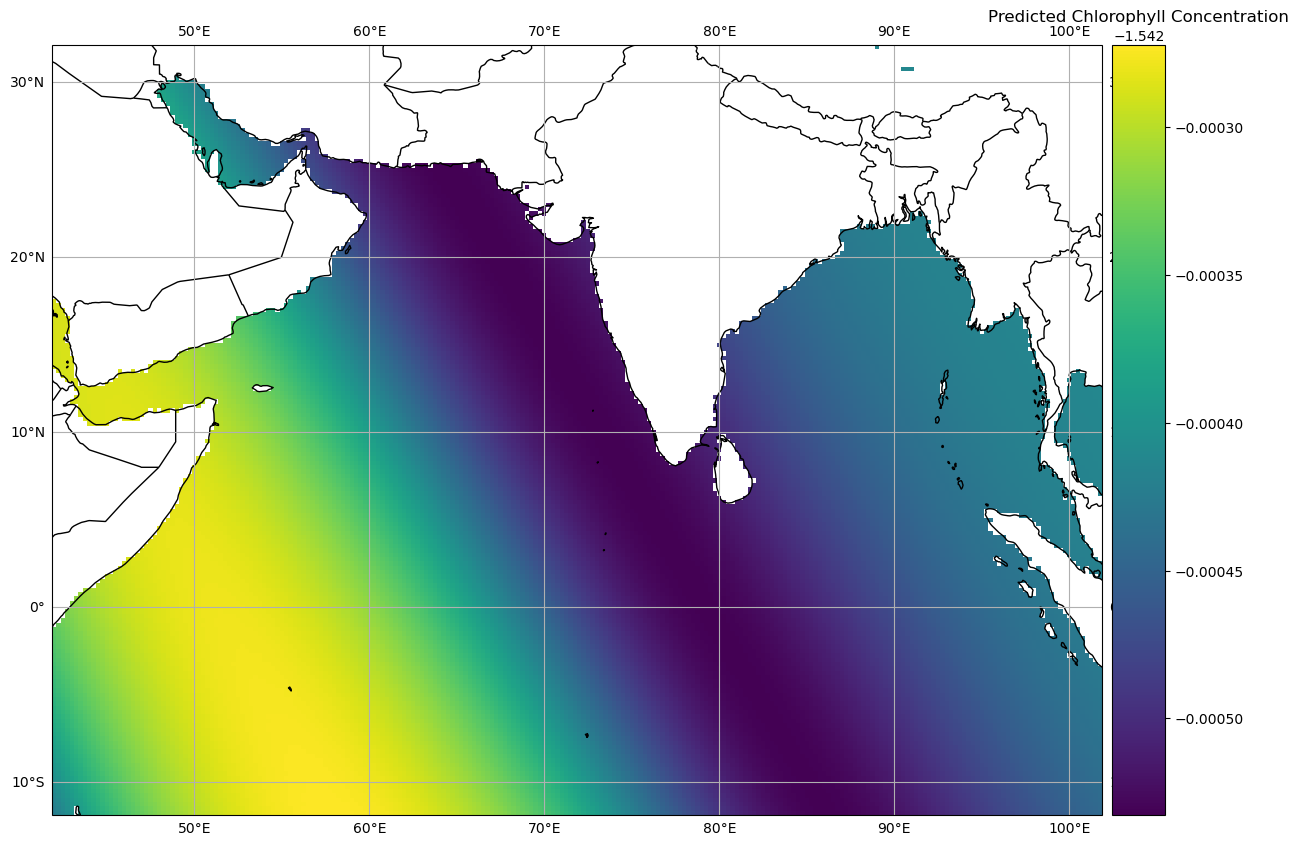

In [51]:
fig, ax = plot_map(chl_pred_grid, "Predicted Chlorophyll Concentration")
